# 라이브러리 import

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 데이터 합치기 -> train.csv로

In [ ]:
train = pd.read_csv("./train.csv", encoding = 'euc-kr')
train['DateTime'] = pd.to_datetime(train.DateTime)
train['date'] = train.DateTime.dt.date
train  = train.groupby('date').sum().reset_index()
train['date'] = pd.to_datetime(train['date'] )
# train

In [ ]:
#facebook prophet 사용

#fbprophet 시계열 예측을 위한 라이브러리
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

#fbprophet에 맞는 dataframe 만들어준다.
date = train.iloc[:,:1]
user = train.iloc[:,1:2]
session = train.iloc[:,2:3]
new = train.iloc[:,3:4]
pageview = train.iloc[:,4:]

df_user = pd.concat([date,user],axis=1)
df_session = pd.concat([date,session],axis=1)
df_new = pd.concat([date,new],axis=1)
df_pageview = pd.concat([date,pageview],axis=1)

user_prophet = df_user.rename(columns={'date': 'ds','사용자': 'y'})
session_prophet = df_session.rename(columns={'date': 'ds','세션': 'y'})
new_prophet = df_new.rename(columns={'date': 'ds','신규방문자': 'y'})
pageview_prophet = df_pageview.rename(columns={'date': 'ds','페이지뷰': 'y'})

new_prophet

,ds,y
0,2018-09-09,73
1,2018-09-10,51
2,2018-09-11,58
3,2018-09-12,45
4,2018-09-13,50
...,...,...
787,2020-11-04,1196
788,2020-11-05,1044
789,2020-11-06,825
790,2020-11-07,531


In [ ]:
m=Prophet(
    # seasonality_mode='multiplicative',
    changepoint_prior_scale=0.3,
    changepoint_range=0.6,
    holidays_prior_scale=25 #홀리데이 반영 강도,
)
m.add_country_holidays(country_name='KOR')
m.fit(user_prophet) #학습 #user_prophet, session_prophet, new_prophet, pageview_prophet

future=m.make_future_dataframe(periods=61) #예측

forecast=m.predict(future)
forecast = forecast.rename(columns={'yhat': '사용자'})
# A = (forecast['yhat_upper'] + forecast['yhat_lower'])/2
A = forecast['사용자']
A = A[-61:].reset_index(drop=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
m=Prophet(
    # seasonality_mode='multiplicative',
    changepoint_prior_scale=0.3,
    changepoint_range=0.6,
    holidays_prior_scale=20 #홀리데이 반영 강도,
)
m.add_country_holidays(country_name='KOR')
m.fit(session_prophet) #학습 #user_prophet, session_prophet, new_prophet, pageview_prophet

future=m.make_future_dataframe(periods=61) #예측

forecast=m.predict(future)
forecast = forecast.rename(columns={'yhat': '세션'})
# B = (forecast['yhat_upper'] + forecast['yhat_lower'])/2
B = forecast['세션']
B = B[-61:].reset_index(drop=True)
B

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0     3301.706983
1     3321.703764
2     3288.651914
3     3278.225618
4     3236.616322
         ...     
56    3743.608671
57    3762.377558
58    3727.970264
59    3716.080963
60    3672.932613
Name: 세션, Length: 61, dtype: float64

In [ ]:
m=Prophet(
    # seasonality_mode='multiplicative',
    changepoint_prior_scale=0.3,
    changepoint_range=0.6,
    holidays_prior_scale=20 #홀리데이 반영 강도,
)
m.add_country_holidays(country_name='KOR')
m.fit(new_prophet) #학습 #user_prophet, session_prophet, new_prophet, pageview_prophet

future=m.make_future_dataframe(periods=61) #예측

forecast=m.predict(future)
forecast = forecast.rename(columns={'yhat': '신규방문자'})
# C = (forecast['yhat_upper'] + forecast['yhat_lower'])/2
C = forecast['신규방문자']
C = C[-61:].reset_index(drop=True)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
m=Prophet(
    # seasonality_mode='multiplicative',
    changepoint_prior_scale=0.3,
    changepoint_range=0.6,
    holidays_prior_scale=20 #홀리데이 반영 강도,
)
m.add_country_holidays(country_name='KOR')
m.fit(pageview_prophet) #학습 #user_prophet, session_prophet, new_prophet, pageview_prophet

future=m.make_future_dataframe(periods=61) #예측

forecast=m.predict(future)
forecast = forecast.rename(columns={'yhat': '페이지뷰'})
# D = (forecast['yhat_upper'] + forecast['yhat_lower'])/2
D = forecast['페이지뷰']
D = D[-61:].reset_index(drop=True)
D

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0     82800.736475
1     82786.632061
2     81427.067638
3     80446.329912
4     79663.055228
          ...     
56    98981.094955
57    98953.028169
58    97607.608391
59    96663.982171
60    95935.099862
Name: 페이지뷰, Length: 61, dtype: float64

In [ ]:
forecast[-20:]

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Alternative holiday of Children's Day,Alternative holiday of Children's Day_lower,Alternative holiday of Children's Day_upper,Alternative holiday of Chuseok,Alternative holiday of Chuseok_lower,Alternative holiday of Chuseok_upper,Alternative holiday of Lunar New Year's Day,Alternative holiday of Lunar New Year's Day_lower,Alternative holiday of Lunar New Year's Day_upper,Alternative public holiday,Alternative public holiday_lower,Alternative public holiday_upper,Birthday of the Buddha,Birthday of the Buddha_lower,Birthday of the Buddha_upper,Children's Day,Children's Day_lower,Children's Day_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Chuseok,Chuseok_lower,Chuseok_upper,Hangeul Day,Hangeul Day_lower,Hangeul Day_upper,Independence Movement Day,Independence Movement Day_lower,Independence Movement Day_upper,Labour Day,Labour Day_lower,Labour Day_upper,Liberation Day,...,Lunar New Year's Day,Lunar New Year's Day_lower,Lunar New Year's Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,National Foundation Day,National Foundation Day_lower,National Foundation Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,The day preceding of Chuseok,The day preceding of Chuseok_lower,The day preceding of Chuseok_upper,The day preceding of Lunar New Year's Day,The day preceding of Lunar New Year's Day_lower,The day preceding of Lunar New Year's Day_upper,The second day of Chuseok,The second day of Chuseok_lower,The second day of Chuseok_upper,The second day of Lunar New Year's Day,The second day of Lunar New Year's Day_lower,The second day of Lunar New Year's Day_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,사용자
833,2020-12-20,3840.480751,2937.936844,3810.661869,3800.264910,3880.004835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-462.492910,-462.492910,-462.492910,0.000000,0.000000,0.000000,-304.317699,-304.317699,-304.317699,-158.175211,-158.175211,-158.175211,0.0,0.0,0.0,3377.987841
834,2020-12-21,3850.012092,3417.363988,4338.308786,3807.114515,3891.632833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.342131,39.342131,39.342131,0.000000,0.000000,0.000000,189.823364,189.823364,189.823364,-150.481233,-150.481233,-150.481233,0.0,0.0,0.0,3889.354223
835,2020-12-22,3859.543432,3431.844957,4351.044930,3815.262294,3903.354952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.147096,42.147096,42.147096,0.000000,0.000000,0.000000,182.783219,182.783219,182.783219,-140.636124,-140.636124,-140.636124,0.0,0.0,0.0,3901.690528
836,2020-12-23,3869.074773,3398.330003,4297.533086,3823.159174,3915.043153,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.307922,-6.307922,-6.307922,0.000000,0.000000,0.000000,122.396317,122.396317,122.396317,-128.704239,-128.704239,-128.704239,0.0,0.0,0.0,3862.766851
837,2020-12-24,3878.606114,3400.482182,4308.647197,3831.193035,3927.029750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

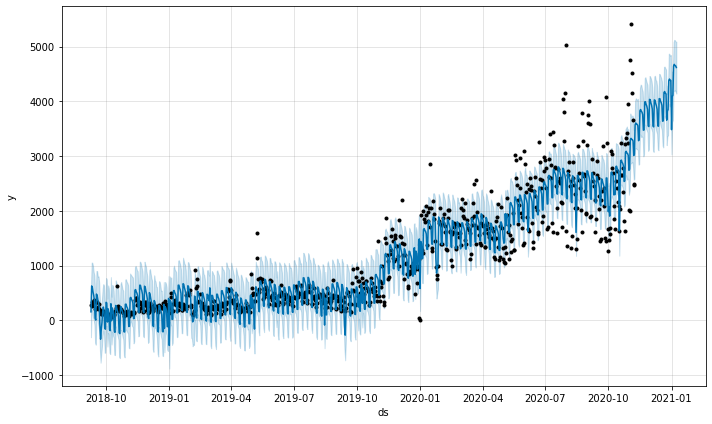

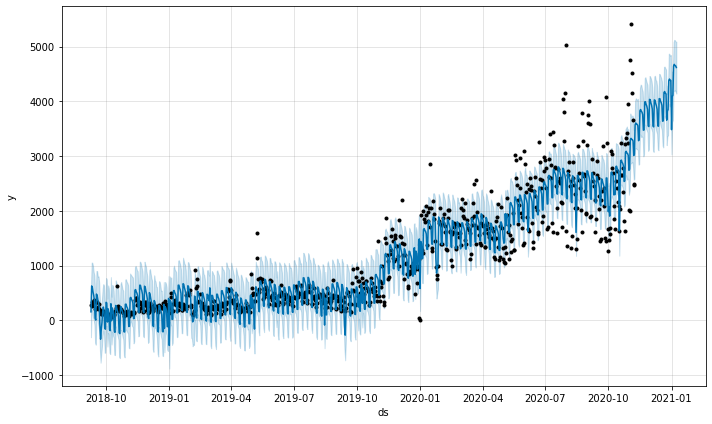

In [ ]:
m.plot(forecast)

In [ ]:
submission = pd.read_csv("./submission.csv", encoding = 'euc-kr')
date2 = submission['DateTime']

In [ ]:
submission = pd.concat([date2,A,B,C,D],axis=1).rename(columns={0: '사용자',1: '세션',2: '신규방문자',3: '페이지뷰'})
submission.head(10)

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,3372.965336,3301.706983,834.086945,82800.736475
1,2020-11-10,3394.118749,3321.703764,849.253872,82786.632061
2,2020-11-11,3361.064823,3288.651914,831.242707,81427.067638
3,2020-11-12,3347.958810,3278.225618,822.315360,80446.329912
4,2020-11-13,3306.838873,3236.616322,814.398140,79663.055228
5,2020-11-14,3023.354345,2950.271308,724.185969,73199.621154
6,2020-11-15,3031.842932,2959.539132,714.256191,73435.430098
7,2020-11-16,3544.567995,3470.250520,862.958818,85765.709386
8,2020-11-17,3555.254868,3479.790343,872.583195,85541.083106
9,2020-11-18,3510.549023,3434.981706,848.782811,83981.272408


In [ ]:
train2 = pd.read_csv("./2차_train.csv", encoding = 'euc-kr')
train2['DateTime'] = pd.to_datetime(train2.DateTime)
train2['date'] = train2.DateTime.dt.date
train2  = train2.groupby('date').sum().reset_index()
train2['date'] = pd.to_datetime(train2['date'] )
train2.head(10)
# train2 = train2.iloc[:]

fig = make_subplots(shared_xaxes=True,rows=4, cols=1)

fig.add_trace(go.Scatter(x=submission['DateTime'], y=submission['사용자'], name='sub_users', mode='lines+markers'), row=1, col=1)
fig.add_trace(go.Scatter(x=train2['date'], y=train2['사용자'], name='real_users', mode='lines+markers', line=dict(color='firebrick', width=1)), row=1, col=1)

fig.add_trace(go.Scatter(x=submission['DateTime'], y=submission['세션'], name='sub_session', mode='lines+markers'), row=2, col=1)
fig.add_trace(go.Scatter(x=train2['date'], y=train2['세션'], name='real_session', mode='lines+markers', line=dict(color='firebrick', width=1)), row=2, col=1)

fig.add_trace(go.Scatter(x=submission['DateTime'], y=submission['신규방문자'], name='sub_new', mode='lines+markers'), row=3, col=1)
fig.add_trace(go.Scatter(x=train2['date'], y=train2['신규방문자'], name='real_new', mode='lines+markers', line=dict(color='firebrick', width=1)), row=3, col=1)

fig.add_trace(go.Scatter(x=submission['DateTime'], y=submission['페이지뷰'], name='sub_users', mode='lines+markers'), row=4, col=1)
fig.add_trace(go.Scatter(x=train2['date'], y=train2['페이지뷰'], name='real_users', mode='lines+markers', line=dict(color='firebrick', width=1)), row=4, col=1)

In [ ]:
submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')